# Introdução as Redes Neurais

tradução livre dos seguinte artigos de Daniel Warfield (Medium), por Domingos Napolitano

[Warfield 2025, Neural Networks — Intuitively and Exhaustively Explained](https://medium.com/intuitively-and-exhaustively-explained/ai-for-the-absolute-novice-intuitively-and-exhaustively-explained-7b353a31e6d7)   
[Warfield 2024, AI for the Absolute Novice — Intuitively and Exhaustively Explained](https://medium.com/intuitively-and-exhaustively-explained/ai-for-the-absolute-novice-intuitively-and-exhaustively-explained-7b353a31e6d7)

# Suas Tarefas:

## 1. Leia os textos subsequentes
## 2. Execute os códigos de Implementação da SimpleNN
## 3. Análise os códigos e os resultados apresnetados
## 4. Continue a leitura sobre Redes neurais e Introdução ao PyTorch
## 5. Usando so códigos para implementação da SimpleNN, com os mesmos dados apresentados, execute as seguintes tarefas:
### a. Proponha 5 novas arquiteturas por exemplo: variando a quantidade de camadas ocultas, numero de neurônios nas camadas, taxa de aprendizado, etc... 
### b. Execute o treinamento de cada uma das arquiteturas propostas
### c. Apresente um gráfico com as Learning Curve
### d. Para cada arquitetura calcule o erro mse, $R^2$ e MAPE (para saber mais sobre esta métricas consulte: [Scikit Learn - Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)
### e. Em uma célula markdown analise e compare os resultados obtidos

# OBS IMPORTANTE
> **Cada item desta TAREFA VALE 2 PONTOS PARA COMPOR A NOTA AC1

## A Teoria Básica da IA

IA, ciência de dados, aprendizado de máquina (*machine learning*); todos esses são termos incrivelmente amplos que abrangem um vasto número de conceitos. Neste artigo, vamos conceituar a IA como o treinamento de um sistema de computador para resolver um problema através da observação de exemplos desse problema sendo resolvido. Esse processo é chamado de **treinamento**.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*e7essyLzWGoFLuq03hWEDA.png)
> **A ideia do treinamento:** Usar dados para ensinar um modelo de IA sobre um problema.

Uma vez que o modelo de IA tenha sido treinado, nós o utilizaremos para fazer **previsões** (*predictions*).

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*FywhMoOmVVucv1zLzWlzvg.png)

> Depois que o modelo foi treinado para entender o problema, podemos usá-lo para fazer uma previsão baseada em uma imagem que ele nunca viu antes.

E é exatamente isso que faremos neste tutorial. Antes de mergulharmos no conteúdo de IA, no entanto, precisamos configurar um ambiente para que possamos começar a executar o código.

# 📘 Rede Neural do Zero (Implementação NumPy)

Este notebook é uma implementação passo a passo de uma Rede Neural Profunda (DNN) criada apenas com matemática básica e a biblioteca `numpy`, sem usar frameworks como PyTorch ou TensorFlow.

Baseado no artigo *"Neural Networks — Intuitively and Exhaustively Explained"* de Daniel Warfield.

## 1. Importação das Bibliotecas

Primeiro, importamos as ferramentas necessárias para manipulação de matrizes e visualização.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
# Configuração para garantir reprodutibilidade nos números aleatórios
np.random.seed(99)

## 2. A Classe da Rede Neural (`SimpleNN`)

Aqui está a implementação completa. Esta classe contém:

* **Inicialização:** Define a arquitetura e inicializa pesos/vieses aleatórios.
* **Forward Pass:** Calcula a previsão da rede.
* **Backward Pass (Backpropagation):** Calcula os gradientes (como os pesos devem mudar).
* **Update:** Atualiza os pesos com base na Taxa de Aprendizado (*Learning Rate*).
* **Train:** O loop que une tudo para aprender.

In [3]:
class SimpleNN:
    def __init__(self, architecture):
        """
        Inicializa a rede neural.
        architecture: lista contendo a qtd de neurônios por camada.
                      Ex: [2, 64, 64, 1] (2 entradas, 2 ocultas de 64, 1 saída)
        """
        self.architecture = architecture
        self.weights = []
        self.biases =  []
        self.losses =  []

        # Inicializa pesos e vieses aleatoriamente
        for i in range(len(architecture) - 1):
            self.weights.append(np.random.uniform(
                low=-1, high=1,
                size=(architecture[i], architecture[i+1])
            ))
            self.biases.append(np.zeros((1, architecture[i+1])))

    @staticmethod
    def relu(x):
        """Função de Ativação ReLU: Retorna x se x > 0, senão 0"""
        return np.maximum(0, x)

    @staticmethod
    def relu_as_weights(x):
        """
        Derivada da ReLU para o Backpropagation.
        Funciona como um filtro: passa o gradiente se o neurônio estava ativo.
        """
        return (x > 0).astype(float)

    def forward(self, X):
        """Passagem direta dos dados pela rede"""
        self.perceptron_inputs = [X]
        self.perceptron_outputs = []

        for W, b in zip(self.weights, self.biases):
            # Projeção Linear (Z = X . W + b)
            Z = np.dot(self.perceptron_inputs[-1], W) + b
            self.perceptron_outputs.append(Z)

            # Se for a última camada, não usa ativação (para regressão linear)
            # Se não, aplica ReLU
            if W is self.weights[-1]:
                A = Z
            else:
                A = self.relu(Z)

            self.perceptron_inputs.append(A)

        return self.perceptron_inputs, self.perceptron_outputs

    def backward(self, perceptron_inputs, perceptron_outputs, target):
        """Calcula os gradientes (o quanto cada peso deve mudar)"""
        weight_changes = []
        bias_changes = []
        m = len(target) # Tamanho do lote

        # Calcula o erro da camada de saída
        # (Predição - Real)
        dA = perceptron_inputs[-1] - target.reshape(-1, 1)

        # Backpropagation: percorre da última camada até a primeira
        for i in reversed(range(len(self.weights))):
            if i == len(self.weights) - 1:
                dZ = dA
            else:
                # Propaga o erro através da derivada da ReLU
                dZ = dA * self.relu_as_weights(perceptron_outputs[i])

            # Calcula gradientes
            dW = np.dot(perceptron_inputs[i].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m

            weight_changes.append(dW)
            bias_changes.append(db)

            if i > 0:
                # Prepara o erro para a próxima iteração (camada anterior)
                dA = np.dot(dZ, self.weights[i].T)

        # Inverte as listas para ficarem na ordem correta (Entrada -> Saída)
        return list(reversed(weight_changes)), list(reversed(bias_changes))

    def update_weights(self, weight_changes, bias_changes, lr):
        """Atualiza os parâmetros da rede"""
        for i in range(len(self.weights)):
            self.weights[i] -= lr * weight_changes[i]
            self.biases[i] -= lr * bias_changes[i]

    def train(self, X, y, epochs, lr=0.01):
        """Loop de treinamento"""
        for epoch in range(epochs):
            # 1. Forward Pass
            inputs, outputs = self.forward(X)
            
            # 2. Backward Pass
            weight_changes, bias_changes = self.backward(inputs, outputs, y)
            
            # 3. Atualizar Pesos
            self.update_weights(weight_changes, bias_changes, lr)

            # Monitorar o progresso
            if epoch % 100 == 0 or epoch == epochs - 1:
                loss = np.mean((inputs[-1].flatten() - y) ** 2)
                print(f"ÉPOCA {epoch}: Perda (Loss) = {loss:.4f}")
                self.losses.append(loss)
                

    def predict(self, X):
        """Faz uma predição final"""
        inputs, _ = self.forward(X)
        return inputs[-1].flatten()

## 3. Gerando Dados Sintéticos

Vamos criar uma função matemática complexa e não-linear para ver se nossa rede neural consegue aprendê-la.

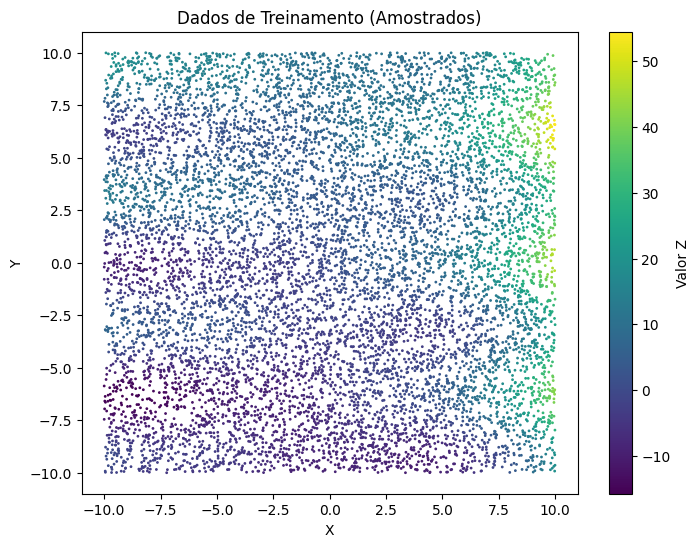

In [4]:
# Definir a função complexa
def random_function(x, y):
    return (np.sin(x) + x * np.cos(y) + y + 3**(x/3))

# Gerar dados de treinamento (10.000 amostras)
n_samples = 10000
x_min, x_max = -10, 10
y_min, y_max = -10, 10

X_random = np.random.uniform(x_min, x_max, n_samples)
Y_random = np.random.uniform(y_min, y_max, n_samples)
Z_random = random_function(X_random, Y_random)

# Visualizar a "Verdadeira Função"
plt.figure(figsize=(8, 6))
plt.scatter(X_random, Y_random, c=Z_random, cmap='viridis', s=1)
plt.title('Dados de Treinamento (Amostrados)')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Valor Z')
plt.show()

## 4. Pré-processamento (Normalização)

Redes neurais têm dificuldade em aprender com números muito grandes ou muito pequenos. Por isso, normalizamos os dados para que tenham média 0 e desvio padrão 1.

In [5]:
# Prepara as entradas (empilha X e Y em uma matriz de duas colunas)
inputs_raw = np.column_stack((X_random, Y_random))
outputs_raw = Z_random

# Calcula médias e desvios padrão
inputs_mean = np.mean(inputs_raw, axis=0)
inputs_std = np.std(inputs_raw, axis=0)
outputs_mean = np.mean(outputs_raw)
outputs_std = np.std(outputs_raw)

# Normaliza (Z-Score Normalization)
inputs = (inputs_raw - inputs_mean) / inputs_std
outputs = (outputs_raw - outputs_mean) / outputs_std

print("Dados normalizados e prontos para treinamento.")

Dados normalizados e prontos para treinamento.


## 5. Treinamento

Agora instanciamos nossa rede e iniciamos o processo de aprendizado.
**Arquitetura:**

* Entrada: 2 neurônios (x, y)
* Oculta 1: 64 neurônios
* Oculta 2: 64 neurônios
* Oculta 3: 64 neurônios
* Saída: 1 neurônio (z)

In [6]:
# Define a arquitetura
architecture = [2, 64, 64, 64, 1]

# Cria o modelo
model = SimpleNN(architecture)

# Treina o modelo
# Nota: Pode levar alguns segundos/minutos dependendo da sua máquina
print("Iniciando treinamento...")
model.train(inputs, outputs, epochs=8000, lr=0.001)

Iniciando treinamento...
ÉPOCA 0: Perda (Loss) = 785.2177
ÉPOCA 100: Perda (Loss) = 0.3678
ÉPOCA 200: Perda (Loss) = 0.2576
ÉPOCA 300: Perda (Loss) = 0.2132
ÉPOCA 400: Perda (Loss) = 0.1857
ÉPOCA 500: Perda (Loss) = 0.1660
ÉPOCA 600: Perda (Loss) = 0.1505
ÉPOCA 700: Perda (Loss) = 0.1380
ÉPOCA 800: Perda (Loss) = 0.1279
ÉPOCA 900: Perda (Loss) = 0.1195
ÉPOCA 1000: Perda (Loss) = 0.1124
ÉPOCA 1100: Perda (Loss) = 0.1063
ÉPOCA 1200: Perda (Loss) = 0.1010
ÉPOCA 1300: Perda (Loss) = 0.0964
ÉPOCA 1400: Perda (Loss) = 0.0923
ÉPOCA 1500: Perda (Loss) = 0.0886
ÉPOCA 1600: Perda (Loss) = 0.0853
ÉPOCA 1700: Perda (Loss) = 0.0823
ÉPOCA 1800: Perda (Loss) = 0.0794
ÉPOCA 1900: Perda (Loss) = 0.0767
ÉPOCA 2000: Perda (Loss) = 0.0741
ÉPOCA 2100: Perda (Loss) = 0.0717
ÉPOCA 2200: Perda (Loss) = 0.0695
ÉPOCA 2300: Perda (Loss) = 0.0674
ÉPOCA 2400: Perda (Loss) = 0.0654
ÉPOCA 2500: Perda (Loss) = 0.0636
ÉPOCA 2600: Perda (Loss) = 0.0618
ÉPOCA 2700: Perda (Loss) = 0.0602
ÉPOCA 2800: Perda (Loss) = 0.0586

# Visualizando o treinamento (Learning Curve)

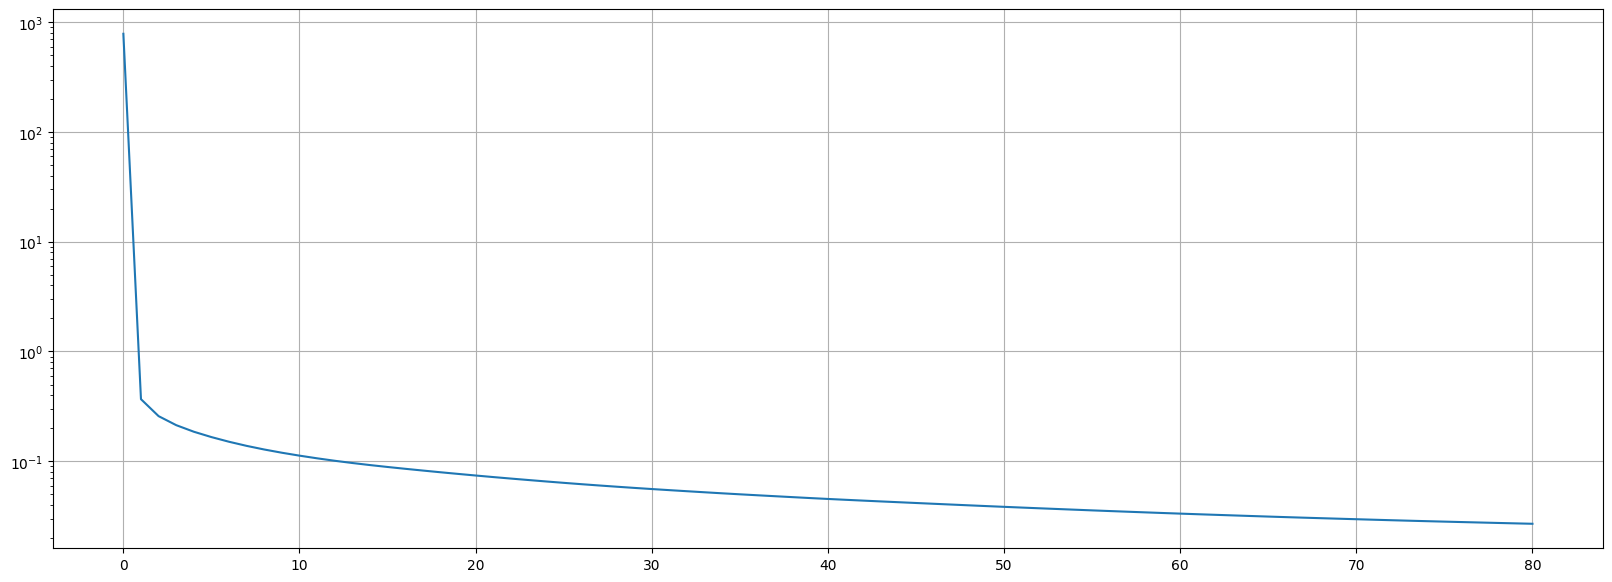

In [11]:
plt.figure(figsize=(20,7))
plt.plot(model.losses)
plt.plot('Learning Curve')
plt.grid()
plt.yscale('log') # Você pode "comentar esta linah se quiser que y seja linear"

## 6. Avaliação e Visualização

Vamos comparar visualmente a função "Real" versus a função que a Rede Neural "Imaginou/Aprendeu".

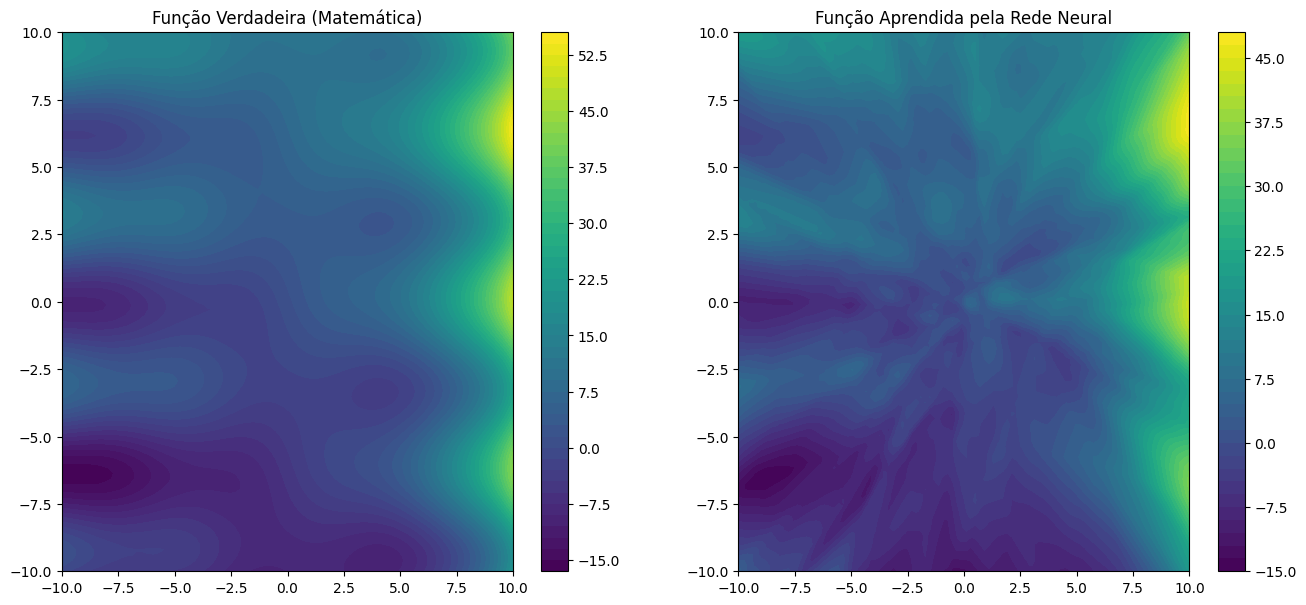

In [12]:
# 1. Cria um grid de pontos para desenhar o contorno suave
x_grid = np.linspace(-10, 10, 100)
y_grid = np.linspace(-10, 10, 100)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

# 2. Calcula a função real nesses pontos
Z_true = random_function(X_mesh, Y_mesh)

# 3. Prepara os dados do grid para a Rede Neural (Achatando e Normalizando)
grid_inputs = np.column_stack((X_mesh.flatten(), Y_mesh.flatten()))
grid_inputs_norm = (grid_inputs - inputs_mean) / inputs_std

# 4. A Rede Neural faz a previsão
pred_norm = model.predict(grid_inputs_norm)

# 5. "Desnormaliza" a previsão para voltar à escala original
Z_pred = pred_norm * outputs_std + outputs_mean
Z_pred = Z_pred.reshape(X_mesh.shape)

# --- PLOTAGEM ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot da Função Real
true_plot = axes[0].contourf(X_mesh, Y_mesh, Z_true, cmap='viridis', levels=50)
axes[0].set_title("Função Verdadeira (Matemática)")
fig.colorbar(true_plot, ax=axes[0])

# Plot da Predição da IA
nn_plot = axes[1].contourf(X_mesh, Y_mesh, Z_pred, cmap='viridis', levels=50)
axes[1].set_title("Função Aprendida pela Rede Neural")
fig.colorbar(nn_plot, ax=axes[1])

plt.show()

# Calculando o $R^2 Score$

In [18]:
r2_score(Z_true, Z_pred)

0.9308321882830799

# Calculando o Erro Médio Quadratico

In [19]:
mean_squared_error(Z_true, Z_pred)

3.602504880283592

# Calulando o Erro Médio Quadratico Percentual (Mean absolute percentage error) MAPE

In [20]:
mean_absolute_percentage_error(Z_true, Z_pred)

0.8515989314437765

# Implementando uma rede Neural com Pytorch

In [21]:
#Instalação
#! pip install torch

## Pytorch Conceito 1 - Tensors

In [22]:
import torch
tensor = torch.tensor([[1.0, -1.0], [2.9, -3.1]])
print(tensor)

tensor([[ 1.0000, -1.0000],
        [ 2.9000, -3.1000]])


### 1. Tensor de Dimensão 0 (Escalar)

Como você mencionou, é apenas um número isolado. Ele não tem direção, apenas magnitude.

* **Exemplo:** A temperatura atual ou o preço de uma ação.
* **Representação:** 

### 2. Tensor de Dimensão 1 (Vetor)

É uma lista ou linha de números. Em computação, frequentemente representa uma "característica" de algo.

* **Exemplo:** As coordenadas  de um ponto ou uma lista de preços de vários produtos.
* **Representação:** 

### 3. Tensor de Dimensão 2 (Matriz)

É uma grade (tabela) de números com linhas e colunas.

* **Exemplo:** Uma planilha de Excel ou uma imagem digital em tons de cinza (onde cada número é o brilho de um pixel).

### 4. Tensor de Dimensão 3 ou Superior

A partir daqui, começamos a "empilhar" matrizes.

* **Exemplo (3D):** Uma imagem colorida. Ela tem altura, largura e 3 camadas de cores (Vermelho, Verde e Azul - RGB).
* **Exemplo (4D):** Um vídeo, que nada mais é do que uma sequência de imagens 3D ao longo do tempo.

In [23]:
# fazendo um 0D tensor
tensor = torch.tensor(42)
print(tensor)

tensor(42)


In [24]:
# fazendo um 1D tensor ou vetor
tensor = torch.tensor([1,2,3,4,5])
print(tensor)

tensor([1, 2, 3, 4, 5])


In [25]:
# fazendo um 2D tensorou matriz
tensor = torch.tensor([[1.0, -1.0], [2.9, -3.1]])
print(tensor)

tensor([[ 1.0000, -1.0000],
        [ 2.9000, -3.1000]])


In [26]:
# fazendo um 3D tensor
tensor = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
print(tensor)

tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])


E assim por diante. Os tensores podem ser arbitrariamente grandes e ter um número arbitrário de dimensões. Uma prática comum ao lidar com tensores é descobrir quantas dimensões eles possuem e qual o tamanho de cada uma dessas dimensões. Podemos fazer isso obtendo o **formato** (*shape*) do tensor.

In [27]:
# verificando shape de um 3D tensor
tensor = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
print(tensor.shape)

torch.Size([2, 2, 2])


Os tensores são usados em todos os lugares na IA. Ao trabalhar em um problema, você transforma quaisquer dados com os quais esteja lidando em um tensor; em seguida, o modelo realiza cálculos matemáticos nesse tensor para transformá-lo em uma saída, que também é um tensor. Os parâmetros do próprio modelo são, de fato, também tensores. Ter uma intuição sobre tensores é muito valioso para entender a IA; no final das contas, tudo se resume a tensores.

## Conceito 2 de PyTorch: Construindo Modelos de IA

Ok, agora vamos realmente construir um modelo simples. No PyTorch, isso é feito criando uma classe que representa o modelo de IA. Essa classe deve herdar de outra classe do PyTorch chamada `Module`.

```python
import torch
import torch.nn as nn #<- usaremos o módulo `nn` dentro do torch com frequência,
                      # por isso o estamos importando separadamente
                      
# Define nosso primeiro modelo de IA
class MyFirstAIModel(nn.Module):
  # a implementação para o nosso modelo

```

Esta é uma abordagem comum para construir modelos de IA no PyTorch. Os criadores do PyTorch desenvolveram uma série de funcionalidades úteis que podemos utilizar simplesmente ao herdar `nn.Module`. Vamos usar isso para criar uma rede neural simples.

Uma rede neural, o modelo de IA prototípico, é um conjunto de "neurônios" conectados uns aos outros. Essas conexões possuem pesos, que são atualizados para mudar a maneira como o modelo "pensa". Entraremos em mais detalhes sobre a teoria disso mais tarde, mas por enquanto, vamos apenas tentar construir uma rede neural qualquer no PyTorch para ter uma ideia de como ele funciona.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*5CAbIf8EVfHBZohkqlX8lA.png)
> Um diagrama conceitual de uma rede neural, que conecta uma entrada representada como um vetor (um tensor 1D) a outro vetor, por meio de muitas conexões inter-relacionadas.

Podemos implementar a rede neural da imagem acima no PyTorch com o seguinte código:

```python
1  import torch.nn as nn
2  
3  # Define a rede neural
4  class MyFirstAIModel(nn.Module):
5    def __init__(self, input_size, hidden_size, output_size):
6      super(MyFirstAIModel, self).__init__()
7      self.fc1 = nn.Linear(input_size, hidden_size)
8      self.fc2 = nn.Linear(hidden_size, output_size)
9  
10   def forward(self, x):
11     x = self.fc1(x)
12     x = self.fc2(x)
13     return x
14 
15 model = MyFirstAIModel(3,4,2)

```

### Explicação linha por linha:

* **Linha 1:** Importamos o `torch.nn`, que contém classes e funções que podemos usar para criar um modelo de IA.
* **Linha 4:** Estamos definindo um novo modelo de IA como uma classe que herda de `nn.Module` com a linha `class MyFirstAIModel(nn.Module):`. Isso significa que nosso modelo herda uma série de funcionalidades com as quais não precisamos nos preocupar.
* **Linha 5:** Estamos definindo a função de inicialização para o `MyFirstAIModel` com a linha `def __init__(self, input_size, hidden_size, output_size):`. Esta é uma função que recebe uma entrada `self` (o que acontece em todas as funções dentro de uma classe), bem como o `input_size` (tamanho da entrada) da nossa rede neural, o `hidden_size` (tamanho da camada oculta no meio) e o `output_size` (tamanho da saída). Basicamente, essas entradas definem o tamanho do nosso modelo.
* **Linha 6:** Dentro da função de inicialização, chamamos a função de inicialização da classe que herdamos (`nn.Module`). O que exatamente essa linha faz? Eu não tenho ideia, e provavelmente 99% dos cientistas de dados também não sabem totalmente. Você pode pesquisar se quiser, mas o objetivo do PyTorch é que você não precise saber tudo. Esta linha configura nosso modelo de IA como um modelo de IA ao executar a inicialização do `nn.Module`.
* **Linha 7:** No PyTorch, uma camada de uma rede neural é chamada de camada linear (`linear layer`). Aqui, estamos dizendo quantas entradas a camada deve ter e quantas saídas ela deve gerar. Camadas lineares também são frequentemente chamadas de camadas totalmente conectadas (*fully connected layers*), daí o nome da variável `fc1`.
* **Linha 8:** Definimos a segunda camada totalmente conectada, `fc2`.
* **Linha 10:** Agora que criamos nossa função de inicialização, podemos especificar como os dados fluem pelo modelo para gerar uma saída. O processo de dar uma entrada ao modelo e fazer com que ele gere uma saída é comumente chamado de "passagem para frente" (*forward pass*). Implementamos o *forward pass* no PyTorch especificando uma função `forward`, que aceita uma entrada (neste caso, `x`).
* **Linha 11:** Passamos a entrada para a nossa primeira camada da rede neural e salvamos o resultado como `x`.
* **Linha 12:** Pegamos a saída da camada anterior (`x`), passamos pela próxima camada e salvamos esse valor como `x`.
* **Linha 13:** Retornamos `x`, devolvendo assim a saída de todo o modelo.
* **Linha 15:** Criamos efetivamente uma instância do modelo, com camadas consistindo de 3 neurônios, 4 neurônios e 2 neurônios.

Podemos prosseguir, criar um tensor e passá-lo pelo nosso modelo para ver o que acontece:

```python
import torch
import torch.nn as nn

# Define a rede neural
class MyFirstAIModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MyFirstAIModel, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = MyFirstAIModel(3,4,2)
data_input = torch.tensor([1, 2, 3], dtype=torch.float32)
output = model(data_input)
print(output)

```

Como você pode ver, inserimos um tensor de comprimento 3 (correspondente às 3 entradas da nossa rede neural) e obtivemos um tensor de comprimento 2 (correspondente às duas saídas da rede neural). Este modelo de IA não foi treinado, então os parâmetros dentro do modelo são aleatórios, e é por isso que obtemos uma saída aleatória.

Neste ponto, você provavelmente tem duas perguntas: o que é `grad_fn` e como treinamos o modelo? Você também pode estar um pouco inseguro sobre a ideia de uma rede neural e como ela realmente funciona. Vamos fazer uma pausa no PyTorch e dedicar um momento para descrever um pouco da teoria por trás da IA.

In [28]:
import torch
import torch.nn as nn

# Define the neural network
class MyFirstAIModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyFirstAIModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = MyFirstAIModel(3,4,2)
data_input = torch.tensor([1, 2, 3], dtype=torch.float32)
output = model(data_input)
print(output)

tensor([ 1.1738, -1.8240], grad_fn=<ViewBackward0>)


## Um pouco mais da Teoria da IA

Naturalmente, a teoria completa da IA é um tópico bastante amplo. Manteremos a teoria restrita ao que é relevante para este artigo.

Vamos retroceder e revisar os conceitos fundamentais de uma rede neural. Por baixo do capô, uma rede neural pode ser conceituada como pontos onde os dados são armazenados e pesos que o modelo utiliza para processar a entrada e transformá-la em algum tipo de saída.
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*5CAbIf8EVfHBZohkqlX8lA.png)
> Os nós de uma rede neural são onde os valores ficam armazenados, e as linhas entre eles representam como os valores de um nó influenciam os valores nos outros nós.

Digamos que você esteja tentando prever se uma imagem contém um cachorro ou um gato. Você poderia "achatar" (*flatten*) a imagem em um vetor, passá-la por uma rede neural e obter dois valores que representam se o modelo acha que aquela imagem é de um cachorro ou de um gato.
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*Pa1Z_1_yobBckP4KdzaLvA.png)
> Um diagrama conceitual de como uma rede neural pode ser usada para prever se uma imagem contém um cachorro ou um gato. A imagem é achatada em um vetor, que passa pela rede neural, resultando em uma previsão. Neste diagrama, apenas um subconjunto das conexões é mostrado, mas entre cada camada existe um conjunto denso de conexões ligando todos os nós de uma camada a todos os nós da camada seguinte.

A rede neural faz essas previsões usando uma combinação de adição e multiplicação. Em cada conexão, existe um **peso** pelo qual a entrada é multiplicada. Cada neurônio possui múltiplas conexões, cujos resultados são todos somados.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*zO8an7gsbkmgh5q0NxN4IQ.png)
> O processo geral de cálculo de valores dentro de uma rede neural. Os neurônios de entrada são multiplicados pelos pesos e, em seguida, os resultados dessas operações são somados para definir o valor de um neurônio futuro.

Quando passamos dados pelo nosso modelo, sempre haverá alguma saída, embora essa saída provavelmente esteja muito errada em um modelo novo. Se dermos ao modelo uma entrada que sabemos conter um cachorro ou um gato, podemos fazer o modelo prever o que ele acha que a imagem contém. Então, podemos usar a discrepância entre o que o modelo previu e o que sabemos ser a verdade para atualizar o modelo e torná-lo melhor. Esse processo é chamado de **treinamento**.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*E9UttHBFaPpz2ybJnf240w.png)
> Um diagrama conceitual do processo de treinamento. Você fornece ao modelo alguns dados onde a saída desejada é conhecida e, em seguida, atualiza o modelo para que ele esteja "menos errado".

A maneira como o treinamento é feito de fato pode ser um pouco complexa, mas o conceito central é bastante simples. Se a saída foi 20% cachorro, e a saída deveria ter sido 100% cachorro, nós simplesmente ajustamos os parâmetros do modelo para que a saída fique um pouco menos errada. Se repetirmos esse processo repetidamente para inúmeras fotos de cães e gatos, terminaremos com um modelo que aprendeu a distinguir uns dos outros.

## O Problema da Linearidade

Um problema com a rede neural simples que definimos anteriormente é que ela é linear. Lembre-se de que, ao definirmos nosso modelo, usamos camadas "lineares" do Torch.

```python
1  import torch.nn as nn
2  
3  
4  class MyFirstAIModel(nn.Module):
5    def __init__(self, input_size, hidden_size, output_size):
6      super(MyFirstAIModel, self).__init__()
7      self.fc1 = nn.Linear(input_size, hidden_size)    #<---- Lembre-se
8      self.fc2 = nn.Linear(hidden_size, output_size)   #<---- Lembre-se
9  
10   def forward(self, x):
11     x = self.fc1(x)
12     x = self.fc2(x)
13     return x

```

Neste modelo, os valores de cada neurônio são calculados com adições e multiplicações simples. No linguajar matemático, dizemos que um neurônio está linearmente relacionado à entrada. Este é o comportamento padrão das camadas `nn.Linear` do PyTorch.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*zO8an7gsbkmgh5q0NxN4IQ.png)
> Cada camada `nn.Linear` calcula uma relação linear simples entre a entrada e a saída. Em outras palavras, os valores na saída são calculados com adições e multiplicações simples.

Isso pode funcionar para alguns problemas, mas muitos problemas no mundo real não podem ser modelados com relações lineares simples. Para contornar isso, introduzimos a não-linearidade no modelo usando algo chamado **"função de ativação"**. Existe uma variedade de funções de ativação, e todas têm o mesmo objetivo: permitir que um modelo linear aprenda relações não-lineares. Veja a função de ativação Sigmóide, por exemplo:

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*Y5Slku4VMpzgEMpGrwQHfw.png)
> A função de ativação Sigmóide. Compreender a matemática específica desta função não é necessário agora. Conceitualmente, porém, é importante reconhecer como a entrada se relaciona com a saída de uma forma não-linear. Podemos usar essa relação complexa para permitir que nosso modelo de IA entenda padrões mais sofisticados.

Esta função mapeia uma entrada para uma saída de forma não-linear. Podemos passar os valores dentro da nossa rede neural por essas funções não-lineares.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*sgaxAj6eamWaeeEagD-a4g.png)
> Muitos modelos de IA usam funções de ativação não-lineares, como a função sigmóide que discutimos anteriormente, entre as camadas lineares.

À medida que o modelo aprende durante o treinamento, ele aprenderá a explorar essas funções não-lineares de uma forma que o torne melhor na tarefa de modelagem subjacente. Embora ainda estejamos usando um modelo com relações lineares, essas relações são passadas por funções não-lineares, o que significa que o modelo pode aprender a usar essas relações complexas para modelar fenômenos complicados.

Ok. Entendemos o básico de Python, entendemos um pouco sobre o PyTorch e como ele funciona, e temos uma compreensão razoável da teoria básica da IA. Acho que finalmente estamos prontos para construir um modelo de IA simples.

## Mãos a Obra - O Problema que Iremos Resolver

Vamos construir um modelo simples baseado no **MNIST**. O MNIST é o "primeiro mestre" (ou *primeiro boss*) de qualquer cientista de dados iniciante. Basicamente, o MNIST consiste em milhares de imagens de números desenhados à mão com seus respectivos rótulos. O objetivo da modelagem no MNIST é prever a qual número cada imagem corresponde.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*nhL1Q6vgbhqIr2U7.png)
> Números desenhados à mão no conjunto de dados MNIST. O objetivo da modelagem no MNIST é prever qual dígito uma imagem específica representa. O conjunto de dados MNIST tem direitos autorais pertencentes a Yann LeCun e Corinna Cortes sob a licença *Creative Commons Attribution-Share Alike 3.0*.

O PyTorch é uma biblioteca grande com muitos recursos. Para manter as coisas organizadas, os desenvolvedores do PyTorch decidiram criar uma biblioteca complementar chamada `torchvision`, que contém utilitários específicos para modelagem de visão computacional. Vamos utilizá-la para baixar o conjunto de dados MNIST.

In [29]:
#Baixando o dataset MNIST

from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [30]:
help(train_data)

Help on MNIST in module torchvision.datasets.mnist object:

class MNIST(torchvision.datasets.vision.VisionDataset)
 |  MNIST(root: Union[str, pathlib.Path], train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
 |  
 |  Args:
 |      root (str or ``pathlib.Path``): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
 |          and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
 |      train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
 |          otherwise from ``t10k-images-idx3-ubyte``.
 |      transform (callable, optional): A function/transform that  takes in a PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that takes in the
 |          target and transforms it.
 |      download (bool,

In [31]:
#imprimindo o formato dos dados.

#60,000 exemplos rotulados de imagens 28x28.
print(train_data.data.shape)

#60,000 labels, correspondendo a uma imagem.
print(train_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


tensor(3)


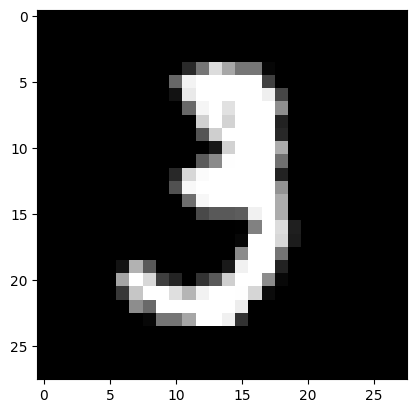

In [32]:
#renderizando um exemplo particular
import matplotlib.pyplot as plt
i = 10
plt.imshow(train_data.data[i], cmap='gray')
print(train_data.targets[i])
plt.show()

Transformando este número numa matriz teráimaos algo assim:

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*J0Em3AA9Ze_HCq6AKnFkiw.png)

Mas as vezes não é tão fácil visuzliar

In [33]:
import torch
torch.set_printoptions(linewidth=200)
i = 10
print(train_data.data[i])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219, 166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254, 254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  18, 232, 254, 254, 254, 254, 254, 238,  

In [34]:
from torch import nn
import torch

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x)
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

#defining the model and printing it.
#it gets re-defined later just so I don't accidentally train the
#same model a few times.
model = MNISTModel()
print(model)

MNISTModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (activation2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [35]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

model = MNISTModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

losses = []

for i, (x, y) in tqdm(enumerate(zip(train_data.data, train_data.targets))):

    #carregando as entradas do modelo
    x = x.type(torch.float32)

    
    y_pred = model.forward(x)

    #reformatando a saída [1,0,0,0,0,0,0,0,0,0] - [0,0,0,0,0,0,0,0,0,1]
    y = F.one_hot(y,10).type(torch.float32)

    loss = loss_fn(y_pred, y)

    # passagem Backward  (corrigindo o modelo com base nos gradientes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #keeping track of loss
    losses.append(float(loss))

0it [00:00, ?it/s]C:\Users\domingos.napolitano\AppData\Local\Temp\ipykernel_10344\307835148.py:30: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  losses.append(float(loss))
60000it [01:26, 691.23it/s]


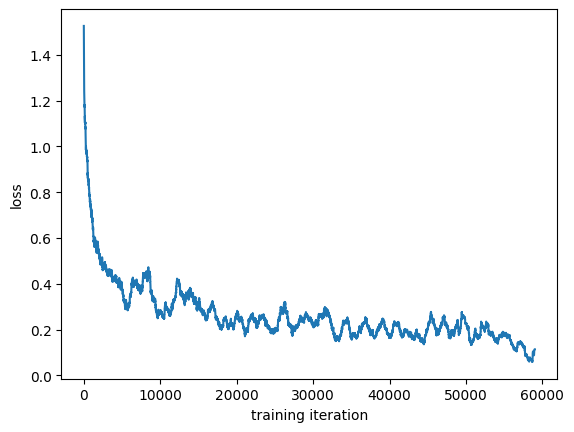

In [36]:
import matplotlib.pyplot as plt
import numpy as np

#if we just plot the noise of individual samples we'll get a very sporadic line'
#this smooths out the trend of our data.
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

plt.plot(moving_avg(losses, 1000))
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.show()

In [37]:
num_true = 0
test_quant = 0

for (x_test, y_test) in zip(test_data.data, test_data.targets):
    #running test example through model
    y_pred_test = model(x_test.type(torch.float32))

    #getting predicted value (highest value)
    y_pred_test = torch.argmax(y_pred_test)

    # print('---')
    # print(y_test)
    # print(y_pred_test)

    #checking to see if the right value was predicted
    if bool(y_pred_test == y_test):
        num_true += 1
    test_quant += 1

print(f'Accuracy %:')
print((num_true/test_quant)*100)

Accuracy %:
94.46


# TAREFAS AC

## 5. Usando so códigos para implementação da SimpleNN, com os mesmos dados apresentados, execute as seguintes tarefas:
### a. Proponha 5 novas arquiteturas por exemplo: variando a quantidade de camadas ocultas, numero de neurônios nas camadas, taxa de aprendizado, etc... 
### b. Execute o treinamento de cada uma das arquiteturas propostas
### c. Apresente um gráfico com as Learning Curve
### d. Para cada arquitetura calcule o erro mse, $R^2$ e MAPE (para saber mais sobre esta métricas consulte: [Scikit Learn - Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)
### e. Em uma célula markdown analise e compare os resultados obtidos

# OBS IMPORTANTE
> **Cada item desta TAREFA VALE 2 PONTOS PARA COMPOR A NOTA AC1**

### a. Proponha 5 novas arquiteturas por exemplo: variando a quantidade de camadas ocultas, numero de neurônios nas camadas, taxa de aprendizado, etc...

### b. Execute o treinamento de cada uma das arquiteturas propostas

### c. Apresente um gráfico com as Learning Curve das 5 arquiteturas

### d. Para cada arquitetura calcule o erro mse, $R^2$ e MAPE (para saber mais sobre esta métricas consulte: [Scikit Learn - Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

### e. Em uma célula markdown analise e compare os resultados obtidos